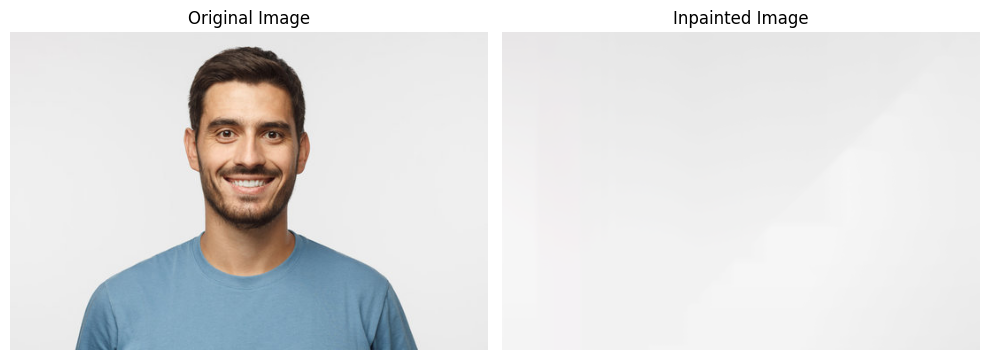

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_inpaint(image_path, output_path="output_inpainted.jpg"):
    
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not load image")
        return
    height, width = img.shape[:2]

    
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    
    mask = np.zeros((height, width), dtype=np.uint8)

    
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  
                
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width * 1.1)  
                h = int(detection[3] * height * 1.1)  
                x = max(0, int(center_x - w / 2))
                y = max(0, int(center_y - h / 2))
                x2 = min(width, x + w)
                y2 = min(height, y + h)

                
                cv2.rectangle(mask, (x, y), (x2, y2), 255, -1)

    
    mask = cv2.GaussianBlur(mask, (15, 15), 0)
    mask = np.where(mask > 50, 255, 0).astype(np.uint8)

    
    inpainted_telea = cv2.inpaint(img, mask, 5, cv2.INPAINT_TELEA)
    inpainted_ns = cv2.inpaint(img, mask, 5, cv2.INPAINT_NS)
    
    
    inpainted_img = cv2.addWeighted(inpainted_telea, 0.5, inpainted_ns, 0.5, 0)

    
    inpainted_img = cv2.medianBlur(inpainted_img, 3)

    
    cv2.imwrite(output_path, inpainted_img)
    
    # use this if you want it to display the images on other windows: 

    # cv2.namedWindow('Original Image', cv2.WINDOW_NORMAL)
    # cv2.namedWindow('Inpainted Result', cv2.WINDOW_NORMAL)
    # cv2.imshow('Original Image', img)
    # cv2.imshow('Inpainted Result', inpainted_img)
    

    original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    inpainted_rgb = cv2.cvtColor(inpainted_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(inpainted_rgb)
    plt.title("Inpainted Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    
    # cv2.resizeWindow('Original Image', width//2, height//2)
    # cv2.resizeWindow('Inpainted Result', width//2, height//2)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()


if __name__ == "__main__":
    image_path = r"F:\opject detect\image.jpg"  
    detect_and_inpaint(image_path)